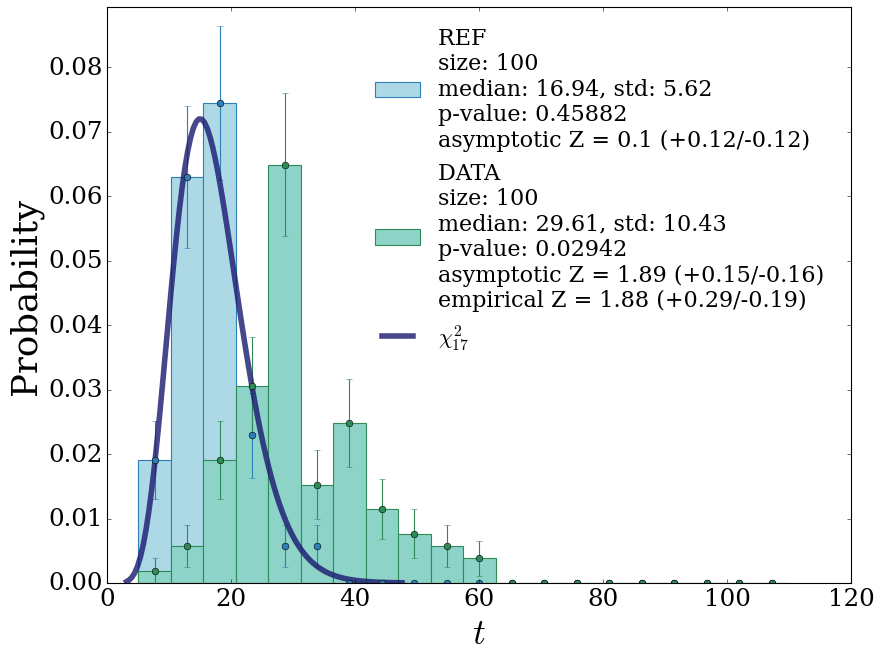

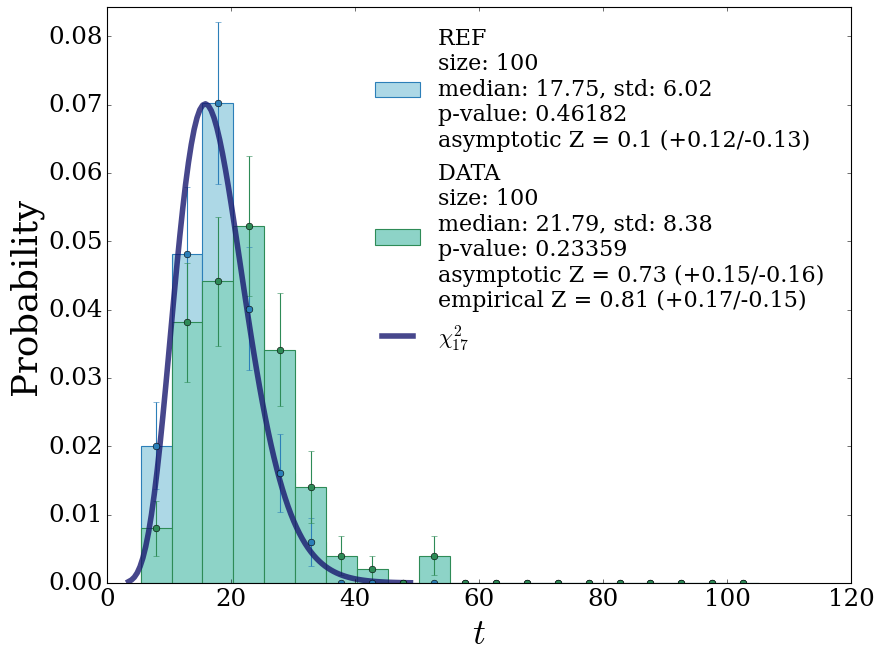

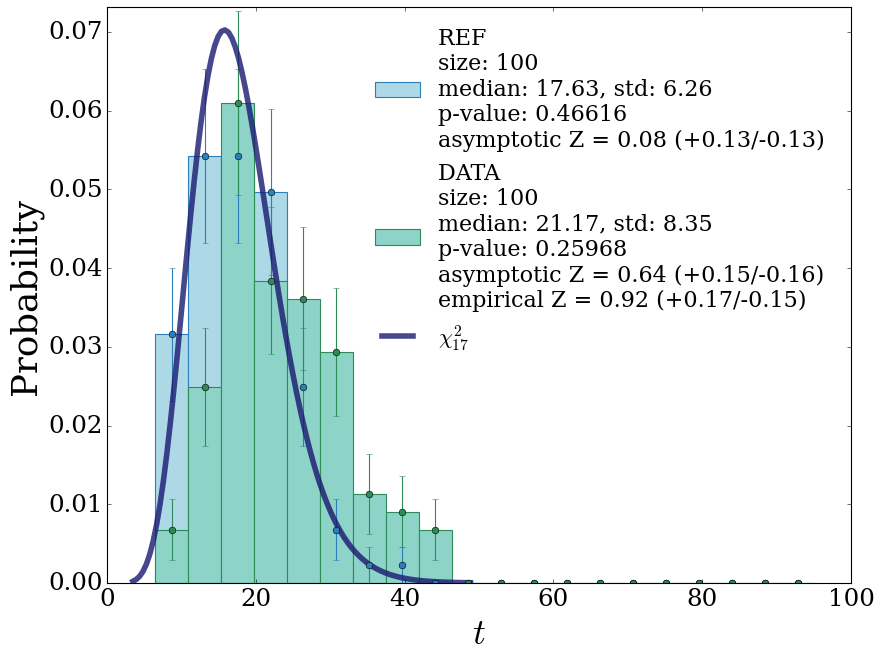

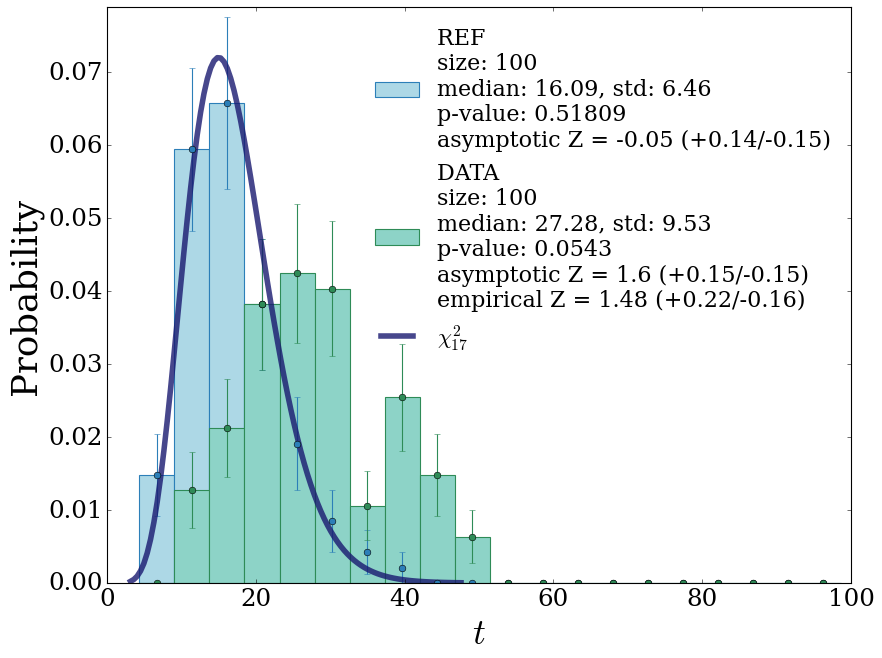

In [3]:
import glob, h5py, math, time, os, json
from scipy.stats import norm, chi2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

# Set plot style
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

# Function to calculate the Z-score and p-value from the chi-squared distribution
def Z_score_chi2(t, df):
    sf = chi2.sf(t, df)  # Survival function (1-CDF) for chi-squared distribution
    Z = -norm.ppf(sf)  # Convert survival function to Z-score
    return Z, sf  # Return both Z-score and p-value (asymptotic p-value)

# Function to plot the histograms and calculate the Z-scores and p-values
def plot_2distribution(t1, t2, df, output_path='/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/', xmin=0, xmax=300, ymax=None, nbins=10, save=True, label1='REF', label2='DATA', save_name='probability_plot', print_Zscore=True):
    '''
    Plot the histogram of two test statistics samples (t1 and t2) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated to determine the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')

    # Plot distribution histogram
    bins = np.linspace(xmin, xmax, nbins + 1)
    binswidth = (xmax - xmin) * 1. / nbins
    
    # p-value: probability of observing a test statistic at least as extreme as the median under the null hypothesis. 
    # Higher p-values suggest a better fit to the expected distribution under the null hypothesis, while lower p-values indicate a less likely fit.

    # Calculate and plot for t1 (reference distribution)
    Z_obs, p_value_obs = Z_score_chi2(np.median(t1), df)  # p-value
    t_obs_err = 1.2533 * np.std(t1) * 1. / np.sqrt(t1.shape[0])  # Error on the median
    Z_obs_p, _ = Z_score_chi2(np.median(t1) + t_obs_err, df)
    Z_obs_m, _ = Z_score_chi2(np.median(t1) - t_obs_err, df)
    label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (label1, t1.shape[0], str(np.around(np.median(t1), 2)), str(np.around(np.std(t1), 2)), str(np.around(p_value_obs, 5)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)' % (str(np.around(Z_obs, 2)), str(np.around(Z_obs_p - Z_obs, 2)), str(np.around(Z_obs - Z_obs_m, 2)))

    h = plt.hist(t1, weights=np.ones_like(t1) * 1. / (t1.shape[0] * binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0] / (t1.shape[0] * binswidth))
    x = 0.5 * (bins[1:] + bins[:-1])
    plt.errorbar(x, h[0], yerr=err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])

    # Calculate and plot for t2 (generated data)
    Z_obs, p_value_obs = Z_score_chi2(np.median(t2), df)  # p-value
    t_obs_err = 1.2533 * np.std(t2) * 1. / np.sqrt(t2.shape[0])  # Error on the median
    Z_obs_p, _ = Z_score_chi2(np.median(t2) + t_obs_err, df)
    Z_obs_m, _ = Z_score_chi2(np.median(t2) - t_obs_err, df)
    t_empirical = np.sum(1. * (t1 > np.mean(t2))) * 1. / t1.shape[0]  
    empirical_lim = '='
    if t_empirical == 0:
        empirical_lim = '>'
        t_empirical = 1. / t1.shape[0]
    t_empirical_err = t_empirical * np.sqrt(1. / np.sum(1. * (t1 > np.mean(t2)) + 1. / t1.shape[0]))
    Z_empirical = norm.ppf(1 - t_empirical)
    Z_empirical_m = norm.ppf(1 - (t_empirical + t_empirical_err))
    Z_empirical_p = norm.ppf(1 - (t_empirical - t_empirical_err))

    label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (label2, t2.shape[0], str(np.around(np.median(t2), 2)), str(np.around(np.std(t2), 2)), str(np.around(p_value_obs, 5)))  # Asymptotic p-value
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n' % (str(np.around(Z_obs, 2)), str(np.around(Z_obs_p - Z_obs, 2)), str(np.around(Z_obs - Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)' % (empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p - Z_empirical, 2)), str(np.around(Z_empirical - Z_empirical_m, 2)))  # Empirical Z-score

    h = plt.hist(t2, weights=np.ones_like(t2) * 1. / (t2.shape[0] * binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0] / (t2.shape[0] * binswidth))
    x = 0.5 * (bins[1:] + bins[:-1])
    plt.errorbar(x, h[0], yerr=err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])

    # Plot reference chi2 distribution
    x = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df), 'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$' % (df))
    font = font_manager.FontProperties(family='serif', size=20)
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2 * np.maximum(max1, max2))
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path == '':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path + save_name + '.pdf')
    plt.show()
    plt.close()
    return [Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m]  # Returning both Z-scores

# Define paths to the HDF5 files containing the test statistics

models = {
    20000: {
        'ref': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_ensemble/calibration/nplm_ensemble_NR100000_NG20000_M1400_lam1e-6_iter1000000_job168552/tvalues_flksigma1.0.h5',
        'data': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_ensemble/comparison/nplm_ensemble_NR100000_NG20000_M1400_lam1e-6_iter1000000_job168311/tvalues_flksigma1.0.h5'
    },
    
    5000: {
        'ref': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/calibration/best_model_NR25000_NG5000_M700_lam1e-6_iter1000000_job610447/tvalues_flksigma3.0.h5',
        'data': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/comparison/best_model_NR25000_NG5000_M700_lam1e-6_iter1000000_job610446/tvalues_flksigma3.0.h5'
    },
    
    10000: {
        'ref': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/calibration/best_model_NR50000_NG10000_M1000_lam1e-6_iter1000000_job610448/tvalues_flksigma3.0.h5',
        'data': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/comparison/best_model_NR50000_NG10000_M1000_lam1e-6_iter1000000_job610449/tvalues_flksigma3.1.h5'
    },
    
    15000: {
        'ref': '/work/gbadarac/MonoJet_NPLM//MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/calibration/best_model_NR75000_NG15000_M1200_lam1e-6_iter1000000_job610451/tvalues_flksigma3.1.h5',
        'data': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/comparison/best_model_NR75000_NG15000_M1200_lam1e-6_iter1000000_job610450/tvalues_flksigma3.0.h5'
    },
    
    20000: {
        'ref': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/calibration/best_model_NR100000_NG20000_M1400_lam1e-6_iter1000000_job610452/tvalues_flksigma3.0.h5',
        'data': '/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_gaussians_outputs/comparison/best_model_NR100000_NG20000_M1400_lam1e-6_iter1000000_job610453/tvalues_flksigma3.0.h5'
    },
    
}

# Initialize lists to store N_generated, p-values, and Z-scores.
N_gen_list = []
p_values_list = []
Z_values_list = []

for N_gen, paths in models.items():
    # Load reference test statistics for current model
    with h5py.File(paths['ref'], 'r') as f_ref:
        flk_sigma = paths['ref'].split('flksigma')[-1].replace('.h5','')
        t1 = np.array(f_ref[flk_sigma])
    
    # Load generated data test statistics for current model
    with h5py.File(paths['data'], 'r') as f_data:
        flk_sigma = paths['data'].split('flksigma')[-1].replace('.h5','')
        t2 = np.array(f_data[flk_sigma])
    
    # Compute degrees of freedom (using the mean of the reference distribution)
    df_model = np.mean(t1)
    
    # Define plotting limits
    xmin = np.min(t1)
    xmax = np.max(t2) + 50
    
    # Extract parameters from the folder name (as in your original code)
    params = '_'.join(paths['ref'].split('/')[-2].split('_')[2:7])
    
    # Plot the distribution comparison for this model using the original naming convention.
    plot_2distribution(
        t1, t2, df_model,
        output_path='/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/NPLM/NPLM_NF_ensemble/',
        xmin=xmin, xmax=xmax, ymax=None, nbins=20, save=True,
        label1='REF', label2='DATA',
        save_name=f'probability_plot_{params}', print_Zscore=True
    )
    
    # Compute the median-based Z-score and p-value for the generated (DATA) distribution.
    Z, p_val = Z_score_chi2(np.median(t2), df_model)
    
    
    # Append results for the summary plots.
    N_gen_list.append(N_gen)
    p_values_list.append(p_val)
    Z_values_list.append(Z)
    

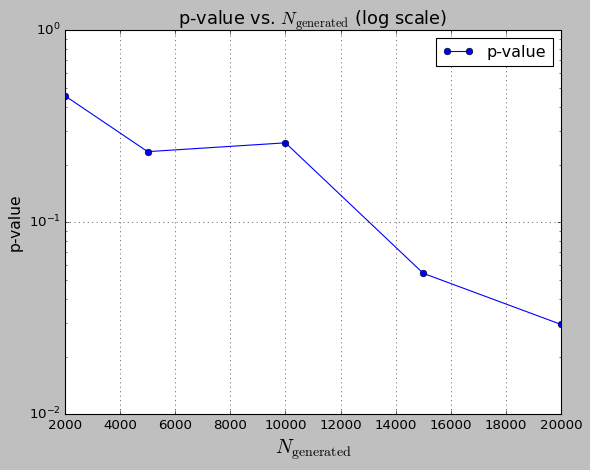

In [2]:
N_gen_array = np.array(N_gen_list)
sort_idx = np.argsort(N_gen_array)
N_gen_array = N_gen_array[sort_idx]
p_values_array = np.array(p_values_list)[sort_idx]
Z_values_array = np.array(Z_values_list)[sort_idx]

plt.figure(figsize=(8,6))
plt.semilogy(N_gen_array, p_values_array, 'o-', label='p-value')
plt.xlabel(r'$N_{\mathrm{generated}}$', fontsize=18)
plt.ylabel('p-value', fontsize=14)
plt.title(r'p-value vs. $N_{\mathrm{generated}}$ (log scale)', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()